# Capsule Networks (CapsNets)

Based on the paper: [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829), by Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017).

Inspired in part from Huadong Liao's implementation: [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow).

**Just as a side note: Using an interactive session in a python notebook/pdb debugger is a good way to learn or develop an algorithm because it allows you to actually go through the layer sizes as the code is running**

# Introduction

Watch [this video](https://youtu.be/pPN8d0E3900) to understand the key ideas behind Capsule Networks:

In [2]:
from IPython.display import HTML
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/pPN8d0E3900" frameborder="0" allowfullscreen></iframe>""")

You may also want to watch [this video](https://youtu.be/2Kawrd5szHE), which presents the main difficulties in this notebook:

In [3]:
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/2Kawrd5szHE" frameborder="0" allowfullscreen></iframe>""")

# Imports

To support both Python 2 and Python 3:

In [4]:
from __future__ import division, print_function, unicode_literals

To plot pretty figures:

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

We will need NumPy and TensorFlow:

In [6]:
import numpy as np
import tensorflow as tf

# Reproducibility

Let's reset the default graph, in case you re-run this notebook without restarting the kernel:

In [7]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Let's set the random seeds so that this notebook always produces the same output:

In [8]:
np.random.seed(42)
tf.set_random_seed(42)

# Load MNIST

Yes, I know, it's MNIST again. But hopefully this powerful idea will work as well on larger datasets, time will tell.

In [9]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Let's look at what these hand-written digit images look like:

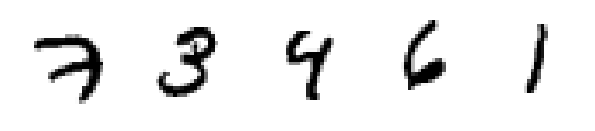

In [10]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

And these are the corresponding labels:

In [11]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

Now let's build a Capsule Network to classify these images. Here's the overall architecture, enjoy the ASCII art! ;-)
Note: for readability, I left out two arrows: Labels → Mask, and Input Images → Reconstruction Loss.

```
                            Loss
                              ↑
                    ┌─────────┴─────────┐
      Labels → Margin Loss      Reconstruction Loss
                    ↑                   ↑
                  Length             Decoder
                    ↑                   ↑ 
             Digit Capsules ────Mask────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Primary Capsules
                    ↑      
               Input Images
```

We are going to build the graph starting from the bottom layer, and gradually move up, left side first. Let's go!

# Input Images

Let's start by creating a placeholder for the input images (28×28 pixels, 1 color channel = grayscale).

In [12]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

# Primary Capsules

The first layer will be composed of 32 maps of 6×6 capsules each, where each capsule will output an 8D activation vector:

In [13]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

To compute their outputs, we first apply two regular convolutional layers:

In [14]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [15]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

Note: since we used a kernel size of 9 and no padding (for some reason, that's what `"valid"` means), the image shrunk by 9-1=8 pixels after each convolutional layer (28×28 to 20×20, then 20×20 to 12×12), and since we used a stride of 2 in the second convolutional layer, the image size was divided by 2. This is how we end up with 6×6 feature maps.

Formula to calculate this stuff:

- Input image dimension: N∗N
- Filter/Kernel size: K∗K
- Stride: S
- Zero padding (filling zeros in to the input image’s sides to control the shrinkage of the output image): P

The next convolution layer size will be (N − K + 2P) / S + 1
- First Layer: (28-9+2*0)/1+1 = (19)+1 = 20
- Second Layer: (20-9)/2+1 = (11/2)+1 = 6.5 - **WTF?  SHOULDNT THE KERNEL SIZE BE 10 THEN???**

Next, we reshape the output to get a bunch of 8D vectors representing the outputs of the primary capsules. The output of `conv2` is an array containing 32×8=256 feature maps for each instance, where each feature map is 6×6. So the shape of this output is (_batch size_, 6, 6, 256). We want to chop the 256 into 32 vectors of 8 dimensions each. We could do this by reshaping to (_batch size_, 6, 6, 32, 8). However, since this first capsule layer will be fully connected to the next capsule layer, we can simply flatten the 6×6 grids. This means we just need to reshape to (_batch size_, 6×6×32, 8).

**Since the first and next capsule layer are fully connected, we dont need to split up the vector (the network can figure out the divisions itself?)**
```
[1]->()\___________/()
[2]->()-|Fully    |-()
[2]->()-|Connected|-()
[3]->()/           \()
```
The divisions dont matter since all the stuff is going to be sent through an fc layer anyway

In [16]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name="caps1_raw")

In [17]:
# When axis is sent to tf.reduce_sum, it means reduce along THAT AXIS
# - (batch_size, 6x6x32, 8) will be reduced to (batch_size, 6x6x32, 1)
x = tf.constant([[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6]], [[2, 2], [2, 3], [2, 4], [2, 5], [2, 6]]])
print("Initial Constant: \n{}".format(x.eval()))
x = tf.reshape(x, [-1, 5, 2], name='ting')
print("Reshaped Constant: {}".format(x.eval().shape))
y = tf.constant([[[1, 2], [1, 3], [1, 4], [1, 5]], [[2, 2], [2, 3], [2, 4], [2, 5]]])
y = tf.reshape(y, [-1, 2, 4])
print("Reshaped Constant y: {}".format(y.eval().shape))
z = tf.matmul(x, y)
print("Matmul shape: {}".format(z.eval().shape))
# IN TENSORFLOW, ONLY NODES THAT NEED TO BE EVALUATED WILL BE - DANGLING PRINTS WONT WORK
l = tf.reduce_sum(x, axis=-1, keep_dims=True)
print("After reduce_sum: \n{}".format(l.eval()))
print("Shape after reduce_sum: {}".format(l.eval().shape))
# Might want to tf.print():
# https://towardsdatascience.com/using-tf-print-in-tensorflow-aa26e1cff11e

Initial Constant: 
[[[1 2]
  [1 3]
  [1 4]
  [1 5]
  [1 6]]

 [[2 2]
  [2 3]
  [2 4]
  [2 5]
  [2 6]]]
Reshaped Constant: (2, 5, 2)
Reshaped Constant y: (2, 2, 4)
Matmul shape: (2, 5, 4)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
After reduce_sum: 
[[[3]
  [4]
  [5]
  [6]
  [7]]

 [[4]
  [5]
  [6]
  [7]
  [8]]]
Shape after reduce_sum: (2, 5, 1)


Now we need to squash these vectors. Let's define the `squash()` function, based on equation (1) from the paper:

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

The `squash()` function will squash all vectors in the given array, along the given axis (by default, the last axis).

**Caution**, a nasty bug is waiting to bite you: the derivative of $\|\mathbf{s}\|$ is undefined when $\|\mathbf{s}\|=0$, so we can't just use `tf.norm()`, or else it will blow up during training: if a vector is zero, the gradients will be `nan`, so when the optimizer updates the variables, they will also become `nan`, and from then on you will be stuck in `nan` land. The solution is to implement the norm manually by computing the square root of the sum of squares plus a tiny epsilon value: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

In [18]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Now let's apply this function to get the output $\mathbf{u}_i$ of each primary capsules $i$ :

In [19]:
caps1_output = squash(caps1_raw, name="caps1_output")

Great! We have the output of the first capsule layer. It wasn't too hard, was it? However, computing the next layer is where the fun really begins.

# Digit Capsules

To compute the output of the digit capsules, we must first compute the predicted output vectors (one for each primary / digit capsule pair). Then we can run the routing by agreement algorithm.

## Compute the Predicted Output Vectors

The digit capsule layer contains 10 capsules (one for each digit) of 16 dimensions each:

- **WOULD IT BE POSSIBLE TO USE FEWER DIGIT CAPSULES AND THEN A FULLY CONNECTED LAYER?  MAYBE IT WOULD BE FASTER - MAYBE??  THE RECONSTRUCTION LOSS IS BASED ON RECONSTRUCTING THE INITIAL IMAGE - NOT NECESSARILY THE CLASS ITSELF**
- **MAYBE WE COULD ALSO TRY RECONSTRUCTING A SMALLER IMAGE??  THAT MIGHT NOT BE DIFFERENTIABLE THOUGH**

In [20]:
caps2_n_caps = 10
caps2_n_dims = 16

For each capsule $i$ in the first layer, we want to predict the output of every capsule $j$ in the second layer. For this, we will need a transformation matrix $\mathbf{W}_{i,j}$ (one for each pair of capsules ($i$, $j$)), then we can compute the predicted output $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ **(equation (2)-right in the paper)**. Since we want to transform an 8D vector into a 16D vector **(ie the dimension of each digit capsule)**, each transformation matrix $\mathbf{W}_{i,j}$ must have a shape of (16, 8).

**Important points regarding matrix multiplication:**
- An mxn matrix is m rows, n columns
- In order for matrix multiplication to be defined, the number of columns in the first matrix must be equal to the number of rows in the second matrix.
- If $\mathbf{A}=[{a}_{ij}]$ is an m×n matrix and $\mathbf{B}=[{b}_{ij}]$ is an n×p matrix, the product AB is an m×p matrix

**Remember: $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ applies for each of the 6x6x32 8 dimensional vectors**

In this case, using: $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$
- Each vector $\mathbf{u}_i$ has shape (8, 1)
- Each input $\hat{\mathbf{u}}_{j|i}$ must be (16, 1)
- Therefore, (x, y)(8, 1) = (16, 1) => (x, y) must be (16, 8)

To compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$), we will use a nice feature of the `tf.matmul()` function: you probably know that it lets you multiply two matrices, but **you may not know that `tf.matmul()` also lets you multiply higher dimensional arrays. It treats the arrays as arrays of matrices, and it performs itemwise matrix multiplication.** For example, suppose you have two 4D arrays, each containing a 2×3 grid of matrices. The first contains matrices $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$ and the second contains matrices $\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$. If you multiply these two 4D arrays using the `tf.matmul()` function, this is what you get:

$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

I think this works because (in numpy at least) matrices are a subset of ndarray

```
a=np.mat('4 3; 2 1')
b=np.mat('1 2; 3 4')
print(a)
# [[4 3]
#  [2 1]]
```
^ The shape for this is (2, 2)
Therefore 2D array of 2x3 grids will be a 4D space - this will give you a 4D array
Source: Experiments and https://stackoverflow.com/questions/4151128/what-are-the-differences-between-numpy-arrays-and-matrices-which-one-should-i-u

We can apply this function to compute $\hat{\mathbf{u}}_{j|i}$ for every pair of capsules ($i$, $j$) like this (recall that there are 6×6×32=1152 capsules in the first layer, and 10 in the second layer):

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$

**Note that the second array must contain 10 identical copies of the vectors $\mathbf{u}_1$ to $\mathbf{u}_{1152}$.**

The shape of the first array (W matrices) is (1152, 10, 16, 8), and the shape of the second array (u matrices) is (1152, 10, 8, 1). To create this array, we will use the handy `tf.tile()` function, which lets you create an array containing many copies of a base array, tiled in any way you want.

Oh, wait a second! We forgot one dimension: _batch size_. Say we feed 50 images to the capsule network, it will make predictions for these 50 images simultaneously. So the shape of the first array (W matrices) must be (50, 1152, 10, 16, 8), and the shape of the second array (u matrices) must be (50, 1152, 10, 8, 1). The first layer capsules actually already output predictions for all 50 images, so the second array will be fine, but for the first array, we will need to use `tf.tile()` to have 50 copies of the transformation matrices.

Okay, let's start by creating a trainable variable of shape (1, 1152, 10, 16, 8) that will hold all the transformation matrices. **The first dimension of size 1 will make this array easy to tile.** We initialize this variable randomly using a normal distribution with a standard deviation to 0.1.

In [21]:
init_sigma = 0.1
W_init_shape = (1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims)
W_init = tf.random_normal(shape=W_init_shape, stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

Now we can create the first array by repeating `W` once per instance/batch:

In [22]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

That's it! On to the second array, now. As discussed earlier, we need to create an array of shape (_batch size_, 1152, 10, 8, 1), containing the output of the first layer capsules, repeated 10 times (once per digit, along the third dimension, which is axis=2). 

The `caps1_output` array has a shape of (_batch size_, 1152, 8), so we first need to expand it twice, to get an array of shape (_batch size_, 1152, 1, 8, 1), then we can repeat it 10 times along the third dimension:

In [23]:
# Is there not a better way to do this???
caps1_output_expanded = tf.expand_dims(caps1_output, -1, name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2, name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")

**Explanation of `tf.expand_dims`:**
- Given a tensor input, this operation inserts a dimension of 1 at the dimension index axis of input's shape. The dimension index axis starts at zero; if you specify a negative number for axis it is counted backward from the end.
- Example:
```
# 't2' is a tensor of shape [2, 3, 5]
tf.shape(tf.expand_dims(t2, 0))  # [1, 2, 3, 5]
tf.shape(tf.expand_dims(t2, 2))  # [2, 3, 1, 5]
tf.shape(tf.expand_dims(t2, 3))  # [2, 3, 5, 1]
```

Let's check the shape of the first array:

In [24]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

Good, and now the second:

In [25]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

Yes! Now, to get all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$, we just need to multiply these two arrays using `tf.matmul()`, as explained earlier: 

In [26]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled, name="caps2_predicted")

Let's check the shape:

In [27]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

Perfect, for each instance in the batch (we don't know the batch size yet, hence the "?") and for each pair of first and second layer capsules (1152×10) we have a 16D predicted output column vector (16×1). We're ready to apply the routing by agreement algorithm!

## Routing by agreement

First let's initialize the raw routing weights $b_{i,j}$ to zero:

In [28]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1], dtype=np.float32, name="raw_weights")

We will see why we need the last two dimensions of size 1 in a minute.

### Round 1

First, let's apply the softmax function to compute the routing weights, $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ (equation (3) in the paper):

In [29]:
# Would it be possible to use a worse, but faster softmax function here?
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


Now let's compute the weighted sum of all the predicted output vectors for each second-layer capsule, $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ (equation (2)-left in the paper):

In [30]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted, name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True, name="weighted_sum")

There are a couple important details to note here:
* To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$ - seems to just be a dot product for matrices?), we use the `tf.multiply()` function. **It requires `routing_weights` and `caps2_predicted` to have the same rank,** which is why we added two extra dimensions of size 1 to `routing_weights`, earlier.
* The shape of `routing_weights` is (_batch size_, 1152, 10, 1, 1) while the shape of `caps2_predicted` is (_batch size_, 1152, 10, 16, 1).  Since they don't match on the fourth dimension (1 _vs_ 16), `tf.multiply()` automatically _broadcasts_ the `routing_weights` 16 times along that dimension. 
    - Broadcasting is the process of making arrays with different shapes have compatible shapes for arithmetic operations. 
    - Broadcasting may be required for operations between multi-dimensional arrays of different ranks, or between multi-dimensional arrays with different but compatible shapes. Consider the addition X+v where X is a matrix (an array of rank 2) and v is a vector (an array of rank 1). To perform element-wise addition, XLA needs to "broadcast" the vector v to the same rank as the matrix X, by replicating v a certain number of times. The vector's length has to match at least one of the dimensions of the matrix.
    - Example:
    ```
    |1 2 3| + |7 8 9|
    |4 5 6|
    
    The matrix's dimensions are (2,3), the vector's are (3). The vector is broadcast by replicating it over rows to get:
    
    |1 2 3| + |7 8 9| = |8  10 12|
    |4 5 6|   |7 8 9|   |11 13 15|
    ```
    - If you are not familiar with broadcasting, a simple example might help:

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

And finally, let's apply the squash function to get the outputs of the second layer capsules at the end of the first iteration of the routing by agreement algorithm, $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [31]:
caps2_output_round_1 = squash(weighted_sum, axis=-2, name="caps2_output_round_1")

In [32]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Good! We have ten 16D output vectors for each instance, as expected.

### Round 2

**Somewhere in here, we are going to have to figure out how to update the weights based on the result.**

First, let's measure how close each predicted vector $\hat{\mathbf{u}}_{j|i}$ is to the actual output vector $\mathbf{v}_j$ by computing their scalar product (aka dot product) $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

* Quick math reminder: if $\vec{a}$ and $\vec{b}$ are two vectors of equal length, and $\mathbf{a}$ and $\mathbf{b}$ are their corresponding column vectors (i.e., matrices with a single column), then $\mathbf{a}^T \mathbf{b}$ (i.e., the matrix multiplication of the transpose of $\mathbf{a}$, and $\mathbf{b}$) is a 1×1 matrix containing the scalar product of the two vectors $\vec{a}\cdot\vec{b}$. In Machine Learning, we generally represent vectors as column vectors, so when we talk about computing the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$, this actually means computing ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$.

Since we need to compute the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ for each instance, and for each pair of first and second level capsules $(i, j)$, we will once again take advantage of the fact that `tf.matmul()` can multiply many matrices simultaneously. **Check if this actually ends up being faster??  Do we even need to tile?  Can we not just use broadcasting from the matmul function?** This will require playing around with `tf.tile()` to get all dimensions to match (except for the last 2), just like we did earlier. So let's look at the shape of `caps2_predicted`, which holds all the predicted output vectors $\hat{\mathbf{u}}_{j|i}$ for each instance and each pair of capsules:

In [33]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

And now let's look at the shape of `caps2_output_round_1`, which holds 10 outputs vectors of 16D each, for each instance:

In [34]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

To get these shapes to match, we just need to tile the `caps2_output_round_1` array 1152 times (once per primary capsule) along the second dimension:

In [35]:
caps2_output_round_1_tiled = tf.tile(caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1], name="caps2_output_round_1_tiled")
caps2_output_round_1_tiled

<tf.Tensor 'caps2_output_round_1_tiled:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

And now we are ready to call `tf.matmul()` **(note that we must tell it to transpose the matrices in the first array, to get ${\hat{\mathbf{u}}_{j|i}}^T$ instead of $\hat{\mathbf{u}}_{j|i}$):**

In [36]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled, transpose_a=True, name="agreement")

We can now update the raw routing weights $b_{i,j}$ by simply adding the scalar product $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ we just computed: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (see Procedure 1, step 7, in the paper).

In [37]:
raw_weights_round_2 = tf.add(raw_weights, agreement, name="raw_weights_round_2")

The rest of round 2 is the same as in round 1:

In [38]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2, dim=2, name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2, caps2_predicted, name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2, axis=1, keep_dims=True, name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2, axis=-2, name="caps2_output_round_2")

We could go on for a few more rounds, by repeating exactly the same steps as in round 2, but to keep things short, we will stop here:

In [39]:
caps2_output = caps2_output_round_2

### Static or Dynamic Loop?

In the code above, we created different operations in the TensorFlow graph for each round of the routing by agreement algorithm. In other words, it's a static loop.

Sure, instead of copy/pasting the code several times, we could have written a `for` loop in Python, but this would not change the fact that the graph would end up containing different operations for each routing iteration. It's actually okay since we generally want less than 5 routing iterations, so the graph won't grow too big.

**^ Sounds like if we use python's "for" loop to implement the building of tensorflow's graph, the graph will contain different operations for each routing iteration.  Nothing will be reused.  This can make the graph massive**

However, you may prefer to implement the routing loop within the TensorFlow graph itself rather than using a Python `for` loop. To do this, you would need to use TensorFlow's `tf.while_loop()` function. This way, all routing iterations would reuse the same operations in the graph, it would be a dynamic loop.

For example, here is how to build a small loop that computes the sum of squares from 1 to 100:

In [40]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


As you can see, the `tf.while_loop()` function expects the loop condition and body to be provided _via_ two functions. These functions will be called only once by TensorFlow, during the graph construction phase, _not_ while executing the graph. The `tf.while_loop()` function stitches together the graph fragments created by `condition()` and `loop_body()` with some additional operations to create the loop.

Also note that during training, TensorFlow will automagically handle backpropogation through the loop, so you don't need to worry about that.

Of course, we could have used this one-liner instead! ;-)

**There are a few Github issues about tf.while_loop being slow... probably want to do a performance comparison here?  There may be a tradeoff btwn graph size and performance.**

In [41]:
sum([i**2 for i in range(1, 100 + 1)])

338350

Joke aside, apart from reducing the graph size, using a dynamic loop instead of a static loop can help reduce how much GPU RAM you use **(if you are using a GPU). Indeed, if you set `swap_memory=True` when calling the `tf.while_loop()` function, TensorFlow will automatically check GPU RAM usage at each loop iteration, and it will take care of swapping memory between the GPU and the CPU when needed.** Since CPU memory is much cheaper and abundant than GPU RAM, this can really make a big difference.

# Estimated Class Probabilities (Length)

The lengths of the output vectors represent the class probabilities, so we could just use `tf.norm()` to compute them, but as we saw when discussing the squash function, it would be risky, so instead let's create our own `safe_norm()` function:

In [42]:
# THIS LOOKS LIKE HOW TO PUT MULTIPLE LAYERS UNDER ONE NAME
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [43]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

To predict the class of each instance, we can just select the one with the highest estimated probability. To do this, let's start by finding its index using `tf.argmax()`:

In [44]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

Let's look at the shape of `y_proba_argmax`:

In [45]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

That's what we wanted: for each instance, we now have the index of the longest output vector. Let's get rid of the last two dimensions by using **`tf.squeeze()` which removes dimensions of size 1.** This gives us the capsule network's predicted class for each instance:

In [46]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [47]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

Okay, we are now ready to define the training operations, starting with the losses.

# Labels

In short, you use `tf.Variable` for trainable variables such as weights (W) and biases (B) for your model.
`tf.placeholder` is used to feed actual training examples.
This is how you feed the training examples during the training:
```
for step in xrange(FLAGS.max_steps):
    feed_dict = {
       images_placeholder: images_feed,
       labels_placeholder: labels_feed,
     }
    _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
```
Your tf.variables will be trained (modified) as the result of this training.
^ https://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable

A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed data into the graph through these placeholders.
Example:
```
import tensorflow as tf

x = tf.placeholder("float", None)
y = x * 2

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [1, 2, 3]})
    print(result)
```
We now have an operation (y) defined, and can now run it in a session. We create a session object, and then run just the y variable. Note that this means, that if we defined a much larger graph of operations, we can run just a small segment of the graph. This subgraph evaluation is actually a bit selling point of TensorFlow, and one that isn’t present in many other libraries that do similar things.

Running y requires knowledge about the values of x. We define these inside the feed_dict argument to run. We state here that the values of x are `[1, 2, 3]`. We run y, giving us the result of `[2, 4, 6]`.

Placeholders do not need to be statically sized. Let’s update our program to allow x to take on any length
^ https://learningtensorflow.com/lesson4/

First, we will need a placeholder for the labels:

In [48]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Margin loss

The paper uses a special margin loss to make it possible to detect two or more different digits in each image:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

My guesses:
- First part: $T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2$ is error if $T_k$ is present (and network guesses its not present)
- Second part: $\lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$ is error if $T_k$ is not present and network detects it anyways
- Looks like $\lambda$ is a weighting factor - we care more about the network missing a value than having a false positive

Official information:
* $T_k$ is equal to 1 if the digit of class $k$ is present, or 0 otherwise.
* In the paper, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$. **ARE THESE HYPERPARAMS???**
* **Note that there was an error in the video (at 15:47): the max operations are squared, not the norms. Sorry about that.**

In [49]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Since `y` will contain the digit classes, from 0 to 9, to get $T_k$ for every instance and every class, we can just use the `tf.one_hot()` function:

In [50]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

A small example should make it clear what this does:

In [51]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Now let's compute the norm of the output vector for each output capsule and each instance. First, let's verify the shape of `caps2_output`:

In [52]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

The 16D output vectors are in the second to last dimension, so let's use the `safe_norm()` function with `axis=-2`:

In [53]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True, name="caps2_output_norm")

Now let's compute $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$, and reshape the result to get a simple matrix of shape (_batch size_, 10):

In [54]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm), name="present_error_raw")
print("present_error_raw: {}".format(present_error_raw))
present_error = tf.reshape(present_error_raw, shape=(-1, 10), name="present_error")
# ^ Could we do a squash for this guy instead??
print("present_error: {}".format(present_error))

present_error_raw: Tensor("present_error_raw:0", shape=(?, 1, 10, 1, 1), dtype=float32)
present_error: Tensor("present_error:0", shape=(?, 10), dtype=float32)


Next let's compute $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ and reshape it:

In [55]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus), name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10), name="absent_error")

We are ready to compute the loss for each instance and each digit:

In [56]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name="L")

Now we can sum the digit losses for each instance ($L_0 + L_1 + \cdots + L_9$), and compute the mean over all instances. This gives us the final margin loss:

In [57]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

# Reconstruction

Now let's add a decoder network on top of the capsule network. It is a regular 3-layer fully connected neural network which will learn to reconstruct the input images based on the output of the capsule network. This will force the capsule network to preserve all the information required to reconstruct the digits, across the whole network. **This constraint regularizes the model: it reduces the risk of overfitting the training set, and it helps generalize to new digits.**

## Mask

The paper mentions that **during training, instead of sending all the outputs of the capsule network to the decoder network, we must send only the output vector of the capsule that corresponds to the target digit (ie the "correct" one I'm guessing?)**

**THIS IS WHY WE CAN'T JUST USE A FULLY CONNECTED LAYER TO ALLOW FOR MORE OUTPUTS THAN CAPSULES - ON THAT NOTE ACTUALLY, MAYBE WE CAN?  THIS MIGHT WORK FOR MULTICLASSIFICATION (EX. CAPSULES 4, 5, 6 TOGETHER CORRESPOND TO 17 OR SOMETHING?).** 

All the other output vectors must be masked out. At inference time, we must mask all output vectors except for the longest one, i.e., the one that corresponds to the predicted digit. You can see this in the paper's figure 2 (at 18:15 in the video): all output vectors are masked out, except for the reconstruction target's output vector.

**We need a placeholder to tell TensorFlow whether we want to mask the output vectors based on the labels (`True`) or on the predictions (`False`, the default):**

In [58]:
mask_with_labels = tf.placeholder_with_default(False, shape=(), name="mask_with_labels")

Now let's use `tf.cond()` to define the reconstruction targets as the labels `y` if `mask_with_labels` is `True`, or `y_pred` otherwise.

`tf.cond()` is tensorflow's `if-else` implementation but has the following difference:
- `tf.cond` is evaluated at runtime, whereas `if-else` is evaluated at the graph construction time.
- If you want to evaluate your condition depending on the value of the tensor at the runtime, `tf.cond` is the best option.

Example:
```
z = tf.multiply(a, b)
result = tf.cond(x < y, lambda: tf.add(x, z), lambda: tf.square(y))
```

In [59]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

Note that the `tf.cond()` function expects the if-True and if-False tensors to be passed _via_ functions: these functions will be called just once during the graph construction phase (not during the execution phase), similar to `tf.while_loop()`. This allows TensorFlow to add the necessary operations to handle the conditional evaluation of the if-True or if-False tensors. However, in our case, the tensors `y` and `y_pred` are already created by the time we call `tf.cond()`, so unfortunately TensorFlow will consider both `y` and `y_pred` to be dependencies of the `reconstruction_targets` tensor. The `reconstruction_targets` tensor will end up with the correct value, but:
1. whenever we evaluate a tensor that depends on `reconstruction_targets`, the `y_pred` tensor will be evaluated (even if `mask_with_layers` is `True`). This is not a big deal because computing `y_pred` adds no computing overhead during training, since we need it anyway to compute the margin loss. And **during testing, if we are doing classification, we won't need reconstructions, so `reconstruction_targets` won't be evaluated at all.**
2. we will always need to feed a value for the `y` placeholder (even if `mask_with_layers` is `False`). This is a bit annoying, but we can pass an empty array, because TensorFlow won't use it anyway (it just does not know it yet when it checks for dependencies).

Now that we have the reconstruction targets, let's create the reconstruction mask. It should be equal to 1.0 for the target class, and 0.0 for the other classes, for each instance. For this we can just use the `tf.one_hot()` function:

**HOW DOES THIS BIT WORK WITH MULTICLASSIFICATION???**

In [60]:
reconstruction_mask = tf.one_hot(reconstruction_targets, depth=caps2_n_caps, name="reconstruction_mask")

Let's check the shape of `reconstruction_mask`:

In [61]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

Let's compare this to the shape of `caps2_output`:

In [62]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Mmh, its shape is (_batch size_, 1, 10, 16, 1). We want to multiply it by the `reconstruction_mask`, **so we are only sending the output of the capsule that corresponds to the correct digit,** but the shape of the `reconstruction_mask` is (_batch size_, 10). We must reshape it to (_batch size_, 1, 10, 1, 1) to make multiplication possible:

In [63]:
reconstruction_mask_reshaped = tf.reshape(reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1], name="reconstruction_mask_reshaped")

At last! We can apply the mask to the capsule's output:

In [64]:
caps2_output_masked = tf.multiply(caps2_output, reconstruction_mask_reshaped, name="caps2_output_masked")

In [65]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

One last reshape operation to flatten the decoder's inputs:

**Remember, the decoder is a 3 layer fully connected network responsible for reconstructing the original input images based on the output from the capsule network.  It is done to deal with overfitting.  Since its a fully connected network, we can (and need to) flatten the input**

In [66]:
decoder_input = tf.reshape(caps2_output_masked, [-1, caps2_n_caps * caps2_n_dims], name="decoder_input")

This gives us an array of shape (_batch size_, 160):

In [67]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

## Decoder

Now let's build the decoder. It's quite simple: two dense (fully connected) ReLU layers followed by a dense output sigmoid layer:

**Notes:**
- Remember, its not the ReLU bit that was the problem with CNNs.  Its actually the MaxPool layer.
- If your image has too much black in it, the relu fucks up, and nodes die.  Your output starts to diverge

In [68]:
n_hidden1 = 512
n_hidden2 = 1024
# The original size of the input image
n_output = 28 * 28

In [69]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output, activation=tf.nn.sigmoid, name="decoder_output")

Info on `tf.name_scope`:
- `name_scope` will add scope as a prefix to all operations
- When creating variables inside of the scope:
    - `tf.Variable()` constructer prefixes variable name with current name_scope and variable_scope
    - `tf.get_variable()` constructor ignores name_scope and only prefixes name with the current variable_scope

Example:
```
with tf.variable_scope("variable_scope"):
     with tf.name_scope("name_scope"):
         var1 = tf.get_variable("var1", [1])

with tf.variable_scope("variable_scope"):
     with tf.name_scope("name_scope"):
         var2 = tf.Variable([1], name="var2")
```

produces as output:

```
var1 = <tf.Variable 'variable_scope/var1:0' shape=(1,) dtype=float32_ref>
var2 = <tf.Variable 'variable_scope/name_scope/var2:0' shape=(1,) dtype=string_ref>
```

- Reusing Variables:
    - Always use `tf.variable_scope` to define the scope of a shared variable
    - The easiest way to do reuse variables is to use the `reuse_variables()` as shown below

```
with tf.variable_scope("scope"):
    var1 = tf.get_variable("variable1",[1])
    tf.get_variable_scope().reuse_variables()
    var2=tf.get_variable("variable1",[1])
assert var1 == var2
```

**Note:** `tf.Variable()` **always creates a new variable**, when a variable is constructed with an already used name it just appends _1, _2 etc. to it - which can cause conflicts :(

Sources:
- https://stackoverflow.com/questions/42708989/why-do-we-use-tf-name-scope?rq=1
- https://stackoverflow.com/questions/34215746/difference-between-variable-scope-and-name-scope-in-tensorflow

## Reconstruction Loss

Now let's compute the reconstruction loss. It is just the squared difference between the input image and the reconstructed image:

In [70]:
# Flatten input image to compare
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output, name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference, name="reconstruction_loss")

## Final Loss

The final loss is the **sum of the margin loss and the reconstruction loss (scaled down by a factor of 0.0005 to ensure the margin loss dominates training)**:

In [71]:
alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

# Final Touches

## Accuracy

To measure our model's accuracy, we need to count the number of instances that are properly classified. For this, we can simply compare `y` (the expected classification) and `y_pred` (predicted classification), convert the boolean value to a float32 (0.0 for False, 1.0 for True), and compute the mean over all the instances:

In [72]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

## Training Operations

The paper mentions that the authors used the Adam optimizer with TensorFlow's default parameters:

In [73]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

## Init and Saver

And let's add the usual variable initializer, as well as a `Saver`:

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And... we're done with the construction phase! Please take a moment to celebrate. :)

**===================================================================================================================**

# Training

Training our capsule network is pretty standard. For simplicity, we won't do any fancy hyperparameter tuning, dropout or anything, we will just run the training operation over and over again, displaying the loss, and at the end of each epoch, measure the accuracy on the validation set, display it, and save the model if the validation loss is the lowest seen found so far (this is a basic way to implement early stopping, without actually stopping). Hopefully the code should be self-explanatory, but here are a few details to note:
* if a checkpoint file exists, it will be restored (this makes it possible to interrupt training, then restart it later from the last checkpoint), **THIS ALSO MEANS A FN WILL NEED TO BE ADDED TO REMOVE THESE FILES**
* we must not forget to feed `mask_with_labels=True` during training,
* during testing, we let `mask_with_labels` default to `False` (but we still feed the labels since they are required to compute the accuracy),
* the images loaded _via_ `mnist.train.next_batch()` are represented as `float32` arrays of shape \[784\], but the input placeholder `X` expects a `float32` array of shape \[28, 28, 1\], so we must reshape the images before we feed them to our model,
* we evaluate the model's loss and accuracy on the full validation set (5,000 instances). To view progress and support systems that don't have a lot of RAM, **the code evaluates the loss and accuracy on one batch at a time, and computes the mean loss and mean accuracy at the end.**

*Warning*: if you don't have a GPU, training will take a very long time (at least a few hours). With a GPU, it should take just a few minutes per epoch (e.g., 6 minutes on an NVidia GeForce GTX 1080Ti).

In [ ]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

# How many batches do we need to process to get through all of the data
n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
# Set best loss to infinity
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        # Init is tf.global_variables_initializer
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            # mask_with_labels was a tf.placeholder we evaluated as a conditional in the graph
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]), y: y_batch, mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Epoch: 1  Val accuracy: 99.2600%  Loss: 0.007954 (improved)
Iteration: 277/1100 (25.2%)  Loss: 0.00016

Training is finished, we reached over 99.4% accuracy on the validation set after just 5 epochs, things are looking good. Now let's evaluate the model on the test set.

# Evaluation

In [ ]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

We reach 99.53% accuracy on the test set. Pretty nice. :)

# Predictions

Now let's make some predictions! We first fix a few images from the test set, then we start a session, restore the trained model, evaluate `caps2_output` to get the capsule network's output vectors, `decoder_output` to get the reconstructions, and `y_pred` to get the class predictions:

In [ ]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

Note: we feed `y` with an empty array, but TensorFlow will not use it, as explained earlier.

And now let's plot the images and their labels, followed by the corresponding reconstructions and predictions:

In [ ]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


The predictions are all correct, and the reconstructions look great. Hurray!

# Interpreting the Output Vectors

Let's tweak the output vectors to see what their pose parameters represent.

First, let's check the shape of the `cap2_output_value` NumPy array:

In [ ]:
caps2_output_value.shape

Let's create a function that will tweak each of the 16 pose parameters (dimensions) in all output vectors. Each tweaked output vector will be identical to the original output vector, except that one of its pose parameters will be incremented by a value varying from -0.5 to 0.5. By default there will be 11 steps (-0.5, -0.4, ..., +0.4, +0.5). This function will return an array of shape (_tweaked pose parameters_=16, _steps_=11, _batch size_=5, 1, 10, 16, 1):

In [ ]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Let's compute all the tweaked output vectors and reshape the result to (_parameters_×_steps_×_instances_, 1, 10, 16, 1) so we can feed the array to the decoder:

In [ ]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Now let's feed these tweaked output vectors to the decoder and get the reconstructions it produces:

In [ ]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

Let's reshape the decoder's output so we can easily iterate on the output dimension, the tweak steps, and the instances:

In [ ]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Lastly, let's plot all the reconstructions, for the first 3 output dimensions, for each tweaking step (column) and each digit (row):

In [ ]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# Conclusion

I tried to make the code in this notebook as flat and linear as possible, to make it easier to follow, but of course in practice you would want to wrap the code in nice reusable functions and classes. For example, you could try implementing your own `PrimaryCapsuleLayer`, and `DenseRoutingCapsuleLayer` classes, with parameters for the number of capsules, the number of routing iterations, whether to use a dynamic loop or a static loop, and so on. For an example a modular implementation of Capsule Networks based on TensorFlow, take a look at the [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) project.

That's all for today, I hope you enjoyed this notebook!